In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
from IPython.display import clear_output
!pip3 install -U lazypredict
!pip3 install -U pandas #판다스 업데이트

clear_output()

Lazypredict을 이용하면 여러 머신러닝 모델을 동시에 학습해서 비교할 수 있다고 한다.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots #데이터 분석과 시각화를 위한 여러 라이브러리 불러오기



from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split # 데이터 가공을 위한 여러 라이브러리 불러오기


from lightgbm import LGBMClassifier
import lazypredict
from lazypredict.Supervised import LazyClassifier # 모델링에 사용할 라이브러리 불러오기

import time
import warnings
warnings.filterwarnings('ignore') # 경고창 표시하지 않음

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
train = pd.read_csv("../input/spaceship-titanic/train.csv") # 학습용 데이터
test = pd.read_csv("../input/spaceship-titanic/test.csv") # 테스트 데이터
submission = pd.read_csv("../input/spaceship-titanic/sample_submission.csv") # 제출용 데이터 불러오기

RANDOM_STATE = 12 
FOLDS = 5
STRATEGY = 'median'

In [5]:
train.head() # 학습데이터 확인

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True


In [6]:
train.shape
train.info()
train.isna().sum() # 데이터 개수와 결측치 확인 -> 대부분 180개 언저리의 결측치가 있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [7]:
print(f'\033[94mNumber of rows in train data: {train.shape[0]}') # 열 개수
print(f'\033[94mNumber of columns in train data: {train.shape[1]}') # 행 개수
print(f'\033[94mNumber of values in train data: {train.count().sum()}') # 총 데이터 개수
print(f'\033[94mNumber missing values in train data: {sum(train.isna().sum())}') # 결측치 수

Number of rows in train data: 8693
Number of columns in train data: 14
Number of values in train data: 119378
Number missing values in train data: 2324


In [8]:
print(f'\033[94m')
print(train.isna().sum().sort_values(ascending = False)) # 결측치가 많은 순서대로 정렬


CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


In [9]:
train.describe() # 기술통계량 확인

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


In [10]:
print(f'\033[94mNumber of rows in test data: {test.shape[0]}')
print(f'\033[94mNumber of columns in test data: {test.shape[1]}')
print(f'\033[94mNumber of values in train data: {test.count().sum()}')
print(f'\033[94mNo of rows with missing values  in test data: {sum(test.isna().sum())}') # 테스트 데이터도 확인

Number of rows in test data: 4277
Number of columns in test data: 13
Number of values in train data: 54484
No of rows with missing values  in test data: 1117


In [11]:
print(f'\033[94m')
print((test.isna().sum().sort_values(ascending = False)))# 결측치 많은 순으로 정렬


FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


In [12]:
test.describe() # 테스트 데이터도 기술통계량 확인

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.00,4195.00,4171.00,4179.00,4176.00,4197.00
mean,28.66,219.27,439.48,177.30,303.05,310.71
std,14.18,607.01,1527.66,560.82,1117.19,1246.99
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,26.00,0.00,0.00,0.00,0.00,0.00
75%,37.00,53.00,78.00,33.00,50.00,36.00
max,79.00,11567.00,25273.00,8292.00,19844.00,22272.00


# EDA

In [13]:
train.drop(["PassengerId"] , axis = 1 , inplace = True) # train에서 승객ID열 제거
test.drop(["PassengerId"] , axis = 1 , inplace = True) # test에서 승객ID열 제거
TARGET = 'Transported'
FEATURES = [col for col in train.columns if col != TARGET]
RANDOM_STATE = 12 

In [15]:
test_null = pd.DataFrame(test.isna().sum())
test_null = test_null.sort_values(by = 0 ,ascending = False)
train_null = pd.DataFrame(train.isna().sum())
train_null = train_null.sort_values(by = 0 ,ascending = False)[:-1]


fig = make_subplots(rows=1, 
                    cols=2,
                    column_titles = ["Train Data", "Test Data"] ,
                    x_title="Missing Values")

fig.add_trace(go.Bar(x=train_null[0],
                     y=train_null.index,
                     orientation="h",
                    marker=dict(color=[n for n in range(12)], 
                                line_color='rgb(0,0,0)' , 
                                line_width = 2,
                                coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x=test_null[0], 
                     y=test_null.index,
                     orientation="h",
                    marker=dict(color=[n for n in range(12)], 
                                line_color='rgb(0,0,0)', 
                                line_width = 2,
                                coloraxis="coloraxis")),
              1, 2)

fig.update_layout(showlegend=False, title_text="Column wise Null Value Distribution", title_x=0.5)

결측값이 적은 것부터 정렬하여 분포 확인

In [16]:
missing_train_row = train.isna().sum(axis=1)
missing_train_row = pd.DataFrame(missing_train_row.value_counts()/train.shape[0]).reset_index()
missing_test_row = test.isna().sum(axis=1)
missing_test_row = pd.DataFrame(missing_test_row.value_counts()/test.shape[0]).reset_index()
missing_train_row.columns = ['no', 'count']
missing_test_row.columns = ['no', 'count']
missing_train_row["count"] = missing_train_row["count"]*100
missing_test_row["count"] = missing_test_row["count"]*100


fig = make_subplots(rows=1, 
                    cols=2,
                    column_titles = ["Train Data", "Test Data"] ,
                    x_title="Missing Values",)

fig.add_trace(go.Bar(x=missing_train_row["no"], 
                     y=missing_train_row["count"]  ,
                    marker=dict(color=[n for n in range(4)], 
                                line_color='rgb(0,0,0)' ,
                                line_width = 3
                                ,coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x= missing_test_row["no"], 
                     y=missing_test_row["count"],
                    marker=dict(color=[n for n in range(4)], 
                                line_color='rgb(0,0,0)',
                                line_width = 3 ,
                                coloraxis="coloraxis")),
              1, 2)
fig.update_layout(showlegend=False, title_text="Row wise Null Value Distribution", title_x=0.5)

각 행마다 결측값이 몇개인지 확인 -> train은 0개가 75%, 1개가 21%, 2개가 2.3%, 3개가 0.2%/ test는 76%, 20%, 2.6%, 0.1% 이다.

In [17]:
df = pd.concat([train[FEATURES], test[FEATURES]], axis=0)
text_features = ["Cabin", "Name"]
cat_features = [col for col in FEATURES if df[col].nunique() < 25 and col not in text_features ]
cont_features = [col for col in FEATURES if df[col].nunique() >= 25 and col not in text_features ]

del df
print(f'\033[94mTotal number of features: {len(FEATURES)}')
print(f'\033[94mNumber of categorical features: {len(cat_features)}')
print(f'\033[94mNumber of continuos features: {len(cont_features)}')
print(f'\033[94mNumber of text features: {len(text_features)}')

labels=['Categorical', 'Continuos', "Text"]
values= [len(cat_features), len(cont_features), len(text_features)]
colors = ['#DE3163', '#58D68D']

fig = go.Figure(data=[go.Pie(
    labels=labels, 
    values=values, pull=[0.1, 0, 0 ],
    marker=dict(colors=colors, 
                line=dict(color='#000000', 
                          width=2))
)])
fig.show()

Total number of features: 12
Number of categorical features: 4
Number of continuos features: 6
Number of text features: 2


데이터가 어떤 종류가 있는지 시각화 - text는 cabin과 name, age같은 연속적인 분포는 continuos, homeplanet같은 여러개로 구분지어지는 분포는 categorical

In [18]:
train_age = train.copy()
test_age = test.copy()
train_age["type"] = "Train"
test_age["type"] = "Test"
ageDf = pd.concat([train_age, test_age])
fig = px.histogram(data_frame = ageDf, 
                   x="Age",
                   color= "type",
                   color_discrete_sequence =  ['#58D68D','#DE3163'],
                   marginal="box",
                   nbins= 100,
                    template="plotly_white"
                )
fig.update_layout(title = "Distribution of Age" , title_x = 0.5)
fig.show()

나이의 분포 시각화하여 확인

ValueError: could not convert string to float: 'Europa'

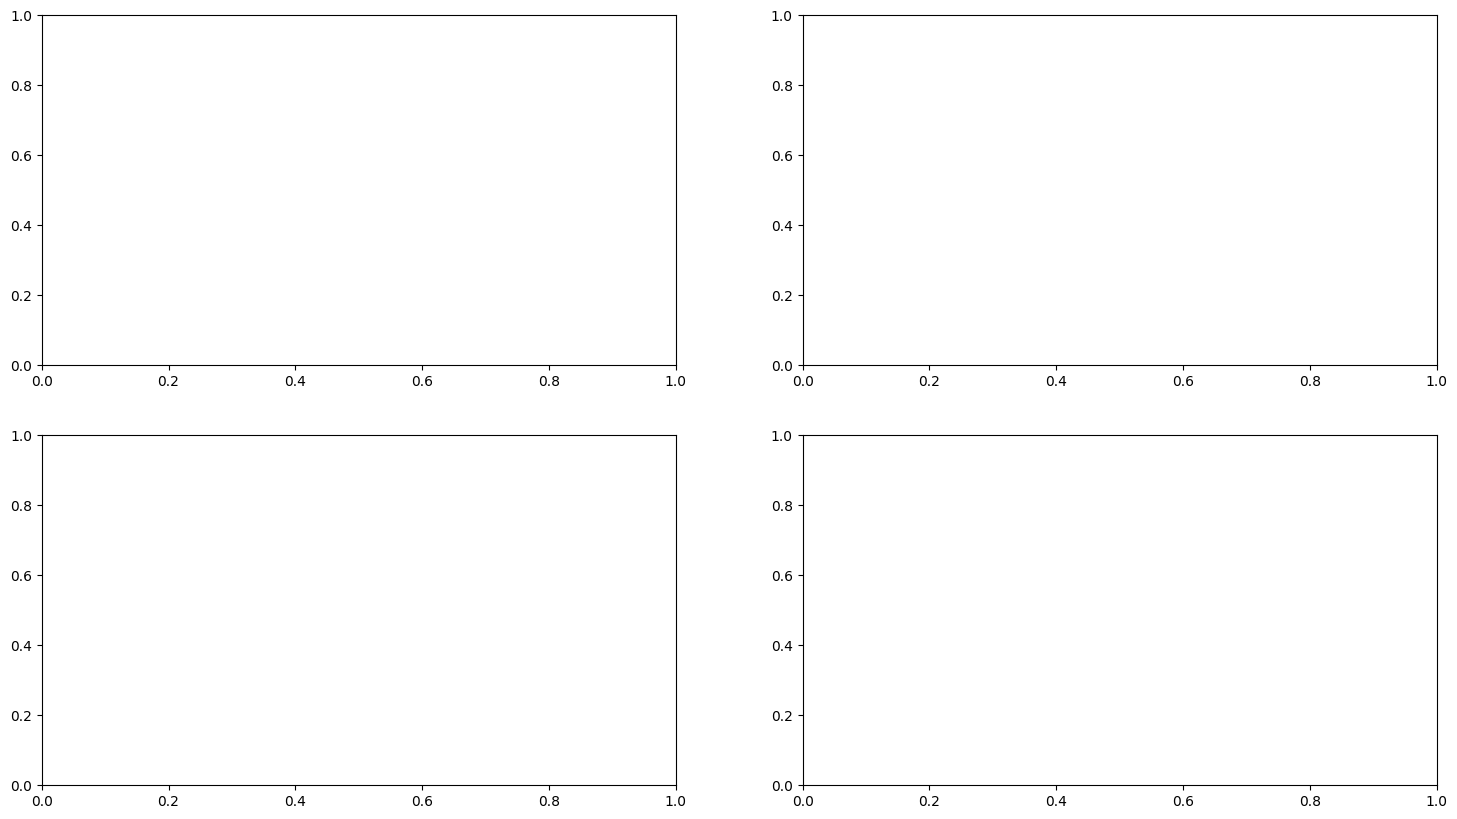

In [19]:
if len(cat_features) == 0 :
    print("No Categorical features")
else:
    ncols = 2
    nrows = 2

    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10))
    for r in range(nrows):
        for c in range(ncols):
            col = cat_features[r*ncols+c]
            sns.countplot(train[col],ax = axes[r,c] ,palette = "viridis", label='Train data')
            sns.countplot(test[col],ax = axes[r,c] ,palette = "magma", label='Test data')
            axes[r,c].legend()
            axes[r,c].set_ylabel('')
            axes[r,c].set_xlabel(col, fontsize=20)
            axes[r,c].tick_params(labelsize=10, width=0.5)
            axes[r,c].xaxis.offsetText.set_fontsize(4)
            axes[r,c].yaxis.offsetText.set_fontsize(4)
    plt.show()

categorical features = homeplanet, cryosleep, destination, vip 시각화(오류뜸)

In [20]:
target_df = pd.DataFrame(train[TARGET].value_counts()).reset_index()
target_df.columns = [TARGET, 'count']
fig = px.bar(data_frame =target_df, 
             x = TARGET,
             y = 'count'
            ) 
fig.update_traces(marker_color =['#58D68D','#DE3163'], 
                  marker_line_color='rgb(0,0,0)',
                  marker_line_width=2,)
fig.update_layout(title = "Target Distribution",
                  template = "plotly_white",
                  title_x = 0.5)
print("\033[94mPercentage of Transported = 0: {:.2f} %".format(target_df["count"][0] *100 / train.shape[0]))
print("\033[94mPercentage of Transported = 1: {:.2f} %".format(target_df["count"][1]* 100 / train.shape[0]))
fig.show()

Percentage of Transported = 0: 50.36 %
Percentage of Transported = 1: 49.64 %


target = transported인 행의 개수와 비율 시각화하여 확인 / 50%정도의 비율을 보임

<AxesSubplot: >

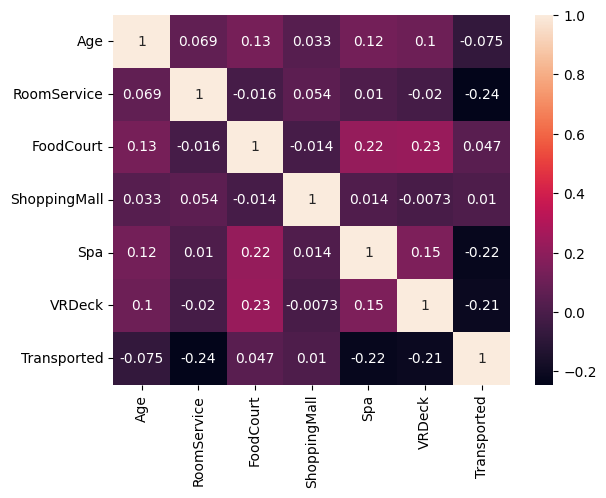

In [21]:
sns.heatmap(train.corr(), annot= True)

상관계수 시각화 후 확인 = transported에 대해 높은게 0.2정도면 높은 상관계수를 가지는 feature는 없는 것 같다.

# 데이터 전처리

In [22]:
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer(strategy=STRATEGY )
imputer.fit(train[imputer_cols])
train[imputer_cols] = imputer.transform(train[imputer_cols])
test[imputer_cols] = imputer.transform(test[imputer_cols])
train["HomePlanet"].fillna('Z', inplace=True)
test["HomePlanet"].fillna('Z', inplace=True)

In [23]:
label_cols = ["HomePlanet", "CryoSleep","Cabin", "Destination" ,"VIP"]
def label_encoder(train,test,columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] =  LabelEncoder().fit_transform(test[col])
    return train, test

train ,test = label_encoder(train,test ,label_cols)

In [24]:
train.drop(["Name" ,"Cabin"] , axis = 1 ,inplace = True) # train에서 name과 cabin 열 제거
test.drop(["Name" ,"Cabin"] , axis = 1 ,inplace = True) # test에서 name과 cabin 열 제거
X = train.drop(TARGET , axis =1 )
y = train[TARGET]
X_train , X_test , y_train , y_test = train_test_split(X , 
                                                       y, 
                                                       random_state = 12 ,
                                                       test_size =0.33)